# Lista 6 - Processos Gaussianos

Aluno: Diego Freitas Holanda

Matricula: 411627

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

# Treino

In [139]:
data = np.genfromtxt('./gp_data_train.csv', delimiter=',')
data.shape

(100, 2)

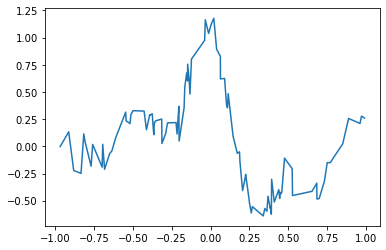

In [140]:
sorted_id = np.argsort(data[:, 0])
X = data[:, 0][sorted_id]
Y = data[:, 1][sorted_id]
sns.lineplot(x=X, y=Y);

## Implementação

In [141]:
class RBF:
    
    def __init__(self, sigma, w):
        self.sigma = sigma
        self.w = w
    
    def calc(self, xi, xj):
        return self.sigma * np.exp(-0.5 * np.sum((w**2) * (xi - xj)**2))

class GP:
    
    def __init__(self, sigma, w, sigmay):
        self.sigma = sigma
        self.w = w
        self.sigmay = sigmay
        self.kernel = RBF(sigma, w)
    
    def fit(self, X: np.ndarray, Y: np.ndarray):
        N = len(X)
        self.X = X
        self.Y = Y
        
        self.mi = np.zeros(N)
        self.K = np.array([[self.kernel.calc(X[i], X[j]) for j in range(N)] for i in range(N)])
        
        temp = np.linalg.inv(self.K + (self.sigmay * np.eye(N)))
        
        self.postmean = self.K @ temp @ Y
        self.postcov = self.K - (self.K @ temp @ self.K)
    
    def predict(self, x: np.ndarray, has_noise: bool=True):
        N = len(X)
        L = np.linalg.cholesky(self.K + self.sigmay * np.eye(self.K.shape[0]))
        linv = np.linalg.inv(L)
        
        kf = np.array([self.kernel.calc(x, self.X[i]) for i in range(N)])
        kk = self.kernel.calc(x,x)
        
        mean = (linv @ kf).T @ linv @ self.Y
        sigma = kk - ((linv @ kf).T @ linv @ kf)
        
        if has_noise:
            sigma += self.sigmay
        
        return mean, sigma
    

In [142]:
sigma = 0.2
sigmay = 0.1
w = 6
model = GP(sigma, w, sigmay)
model.fit(X, Y)

## Priori

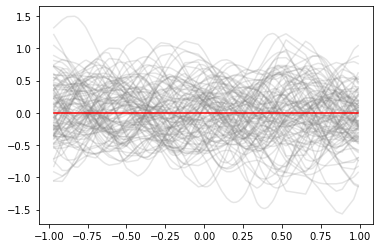

In [143]:
g = multivariate_normal(mean=model.mi, cov=model.K, allow_singular=True)
for y_pred in g.rvs(size=100):
    plt.plot(X, y_pred, alpha=0.2, c='grey');
plt.plot(X, g.mean, c='red', alpha=1);

## Posteriori

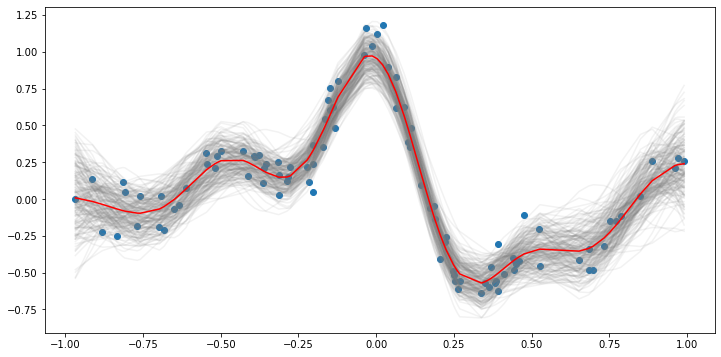

In [144]:
plt.figure(figsize=(12,6))
g = multivariate_normal(mean=model.postmean, cov=model.postcov, allow_singular=True)
for y_pred in g.rvs(size=200):
    plt.plot(X, y_pred, alpha=0.1, c='grey');
plt.plot(X, g.mean, c='red', alpha=1);
plt.scatter(X, Y, alpha=1);

In [145]:
y_pred_train = []
stds = []
for x in X:
    m, s = model.predict(x)
    y_pred_train.append(m)
    stds.append(s)
y_pred_train = np.array(y_pred_train)
stds = np.array(stds)

In [146]:
def NLPD(mean, var, y_true):
    return 0.5*np.log(2*np.pi) + np.mean(0.5*(np.log(var) + ((y_true - mean)**2 )/ var))


def RMSE(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    return np.mean((y_true - y_pred)**2, axis=0)**(1/2)

train_rmse = RMSE(y_pred_train, Y)
train_nlpd = NLPD(y_pred_train, stds, Y)

## Resultados

TRAINNIG METRICS
TRAIN RMSE: 0.10377422368829088
TRAIN NLPD: -0.13443597943075103


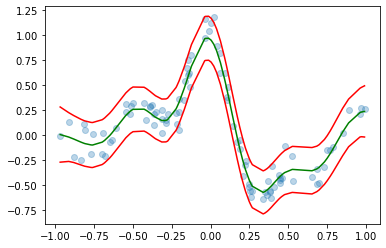

In [147]:
plt.plot(X, y_pred_train, c='green');
plt.plot(X, y_pred_train + 2*stds, c='red')
plt.plot(X, y_pred_train - 2*stds, c='red');
plt.scatter(X, Y, alpha=.3);
print('TRAINNIG METRICS')
print('TRAIN RMSE:', train_rmse)
print('TRAIN NLPD:', train_nlpd)

# Teste

In [148]:
test = np.genfromtxt('./gp_data_test.csv', delimiter=',')
x_test = test[:, 0]
y_test = test[:, 1]

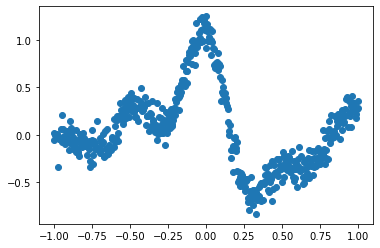

In [149]:
plt.scatter(x_test, y_test);

In [150]:
y_pred_test = []
test_stds = []
for x in x_test:
    m, s = model.predict(x)
    y_pred_test.append(m)
    test_stds.append(s)
y_pred_test = np.array(y_pred_test)
test_stds = np.array(test_stds)

## Resultados

TEST METRICS
TEST RMSE: 0.10880288664369306
TEST NLPD: -0.1202458068093184


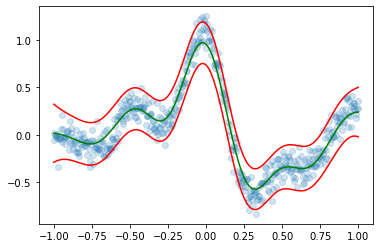

In [151]:
plt.plot(x_test, y_pred_test, c='green');
plt.plot(x_test, y_pred_test + 2*test_stds, c='red')
plt.plot(x_test, y_pred_test - 2*test_stds , c='red');
plt.scatter(x_test, y_test, alpha=.2);

test_rmse = RMSE(y_pred_test, y_test)
test_nlpd = NLPD(y_pred_test, test_stds, y_test)
print('TEST METRICS')
print('TEST RMSE:', test_rmse)
print('TEST NLPD:', test_nlpd)